### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver
import time

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
States_track =collections.defaultdict(dict)

In [4]:
def tracked_states_init():
    state_action_pair = [((2, 0, 0), (0, 0)),
                         ((4, 18, 5), (1, 3)),
                         ((4, 9, 0), (0, 0)),
                         ((1, 9, 1), (0, 0)),
                         ((4, 0, 2), (3, 2)),
                         ((0, 6, 0), (4, 1)),
                         ((3, 0, 3), (0, 0)),
                         ((1, 9, 0), (3, 1)),
                         ((1, 0, 0), (1, 2)),
                         ((4, 4, 4), (4, 1))]
    for state, action in state_action_pair:
        States_track[state][action] = []

In [5]:
tracked_states_init()

In [6]:
# Function to save q-value for tracking states-action pair
def save_tracking_states(curr_state, curr_action, curr_q_value):
    for state in States_track.keys():
        if state == curr_state:
            for action in States_track[state].keys():
                if action == curr_action:
                    States_track[state][action].append(curr_q_value)

In [7]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01       
        self.epsilon_max = 1
        self.epsilon = 1
        self.epsilon_decay = 0.0001
        self.epsilon_min = 0.00001
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        self.states_tracked = []
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()


    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets   
        model.add(Dense(64,input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, possible_actions_index):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment 
        if np.random.rand() <= self.epsilon:
            return random.choice(possible_actions_index)
        else:
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)
            q_value = self.model.predict(state)
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]
            return possible_actions_index[np.argmax(q_vals_possible)]


    def append_sample(self, state, action, reward, next_state, done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, done))

    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            update_output = np.zeros((self.batch_size, self.state_size)) # write here
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
             
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
                
            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):                
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0) 


    def save(self, name):
        self.model.save(name)
        
    def save_tracking_states(self):
        q_value = self.model.predict(self.track_state)
        self.states_tracked.append(q_value[0][2])

    def save_test_states(self):
        q_value = self.model.predict(self.track_state)
        self.states_test.append(q_value[0][2])                                    

In [9]:
Episodes = 10000

### DQN block

In [10]:
episode_time = 24*30
m = 5
t = 24
d = 7
state_size = m+t+d
env = CabDriver()
action_space, state_space, state = env.reset()
action_size = len(action_space)
score_tracked = []
rewards_per_episode, episodes = [], []
rewards_init_state = []

In [11]:
start_time = time.time()
for episode in range(Episodes):
    env = CabDriver()
    action_space, state_space, state = env.reset()
    initial_state = env.state_init
    score = 0 
    terminal_state = False
    total_time = 0

    #Call the DQN agent
    agent = DQNAgent(action_size=action_size, state_size=state_size)
    while not terminal_state:
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        possible_actions_indices, actions = env.requests(state)
        # print("possible_actions_indices %s " %(str(possible_actions_indices)))
        action = agent.get_action(state, possible_actions_indices)       
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        total_time += step_time
        
        if (total_time > episode_time):
            terminal_state = True
        else:
            agent.append_sample(state, action, reward, next_state, terminal_state)
            agent.train_model()
            score += reward
            state = next_state

    rewards_per_episode.append(score)
    episodes.append(episode)
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    if episode % 100 == 0 and episode != 0:
        print("episode -> %s reward -> %s total_time -> %s" %(episode, score, total_time))

    # Save the Q_value of the state, action pair we are tracking
    if episode % 10 == 0:
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    if episode % 1000 == 0:
        print("Saving the model for episode: %s" %(episode))
        agent.save(name="model_weights.pkl")
    
elapsed_time = time.time() - start_time
print(elapsed_time)


Saving the model for episode: 0
1631.8711371421814


In [12]:
agent.save(name="model_weights.pkl")

### Tracking Convergence

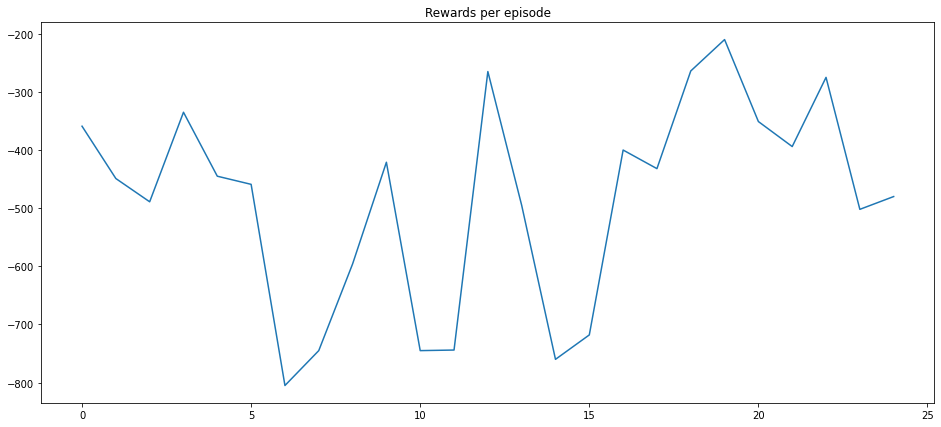

In [16]:
### Tracking rewards per episode
score_tracked_sample = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]
plt.figure(0, figsize=(15,10))
plt.title('Rewards per episode')
X_data = np.asarray(range(0, len(score_tracked_sample)))
plt.plot(X_data,np.asarray(score_tracked_sample))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [6]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

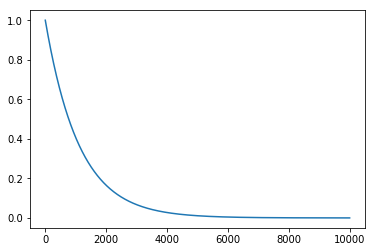

In [7]:
plt.plot(time, epsilon)
plt.show()